<a href="https://colab.research.google.com/github/fnal-cpc/bootcamp/blob/master/mcmc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Markov Chain Monte Carlo

This is a tutorial on Markov Chain Monte Carlo that has consulted [KIPAC computing boot camp](http://kipac.github.io/BootCamp) and edited for the CPC Bootcamp.

Authors: Yuanyuan Zhang [Sean McLaughlin](http://github.com/mclaughlin6464), [Joe Derose](http://github.com/j-dr)

Markov Chain Monte Carlo (MCMC) is a widely-used method to sample multi-dimensional distributions. In this section, we will first explore how to use a MCMC sampler, and then experiment with a scenario that uses the MCMC sampler to explore parameter constraints. We'll be using the MCMC sampler, `emcee`,  written by astronomer (Foreman-Mackey et al. 2012) [link text](https://emcee.readthedocs.io/en/stable/). If you don't have it already, it can be installed with `pip install emcee`. 

First, let's use `emcee` to sample a 2D Gaussian distribution, which has the following probability density function (PDF). 
$$ P(x, y) = \frac{1}{2 \pi \sigma _{x} \sigma _{y}\sqrt{1-\rho^2}} \mathrm{exp}\left( - \frac{1}{2 \sqrt{1-\rho^2}}  \left[\frac {(x-\mu _{x})^{2} } {\sigma _{x}^{2}} + \frac {(y-\mu _{y})^{2} } {\sigma _{y}^{2}} -{\frac {2\rho (x-\mu _{X})(y-\mu _{Y})}{\sigma _{X}\sigma _{Y}}}\right]\right)$$

We'll be sampling a set of (x, y) values with the goal that it matches the density function described above. 

For `emcee` to work, we first need to write a log likelihood function, that gives the log value of the probability above for any given set of (x, y).  Because of how the MCMC algorithms operate (e.g., [Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis–Hastings_algorithm)), the normalization of the PDF usually doesn't matter. 


In [0]:
## setting up the dependencies ## 
!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng
!pip install emcee
!pip install ChainConsumer

Reading package lists... Done
Building dependency tree       
Reading state information... Done
dvipng is already the newest version (1.15-1).
texlive-fonts-recommended is already the newest version (2017.20180305-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.


In [0]:
import emcee
import numpy as np
import time


def ln_like(theta, mu_x, mu_y, rho, sig_x, sig_y):
        x, y =theta
        lp=-np.inf
        lp=  -0.5/(1-rho**2)* ((x - mu_x)**2/sig_x**2 + (y - mu_y)**2/sig_y**2  - 2.0 * rho * (x-mu_x)* (y-mu_y)/sig_x/sig_y)
        return lp

Now we set up `emcee` to sample from the log likelihood function we defined above. 



In [0]:
ndim=2 # because we sample a 2-D distribution
nwalkers=10 # Related to the emcee package. 10 is enough here. Consult emcee manual when setting up your own sampling process.

mu_x = 0.0; mu_y = 0.0; rho = 0.5; sig_x = 1.0 ;sig_y = 1.0 # parameters specifiyin gthe 2D gaussian dist.
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_like, args=(mu_x, mu_y, rho, sig_x, sig_y) )  # settin gup the emcee sampler


t0 = time.time() # just for some extra fun, we are recording how much time the sampling takes. 
# emcee sampler needs to be "initiated", e.g., what (x, y) values to start on. 
# Consult the manual when setting up your own initialization values
# here I am trying to give some bad guesses to give the sampler a harder time.
p0=np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim)) * 0.001 

# now let's start sampling
nstep =5000 # this says that we want to sample nstep=10000 sets of (x,y) values
pos, prob, state = sampler.run_mcmc(p0, nstep)
samples = sampler.chain[:, :, :].reshape((-1, ndim)) # here is the sampled sets of (x, y) values. 
t1=time.time()
print( ' Done with sampling -- time (seconds): ',t1-t0)

(' Done with sampling -- time (seconds): ', 2.4201250076293945)


So MCMC samplers usually start from the initalization values, take some time to arrive at the state that comfortably sample the whole distribution, and eventurally start to give values that represent the distribution. We can see how it works by looking at the trace plots of the samples. 

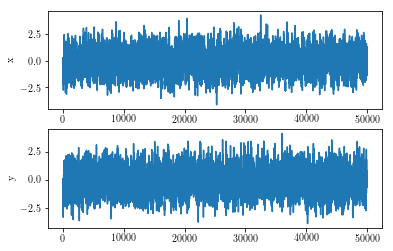

In [0]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1)
axs[0].plot(samples[:, 0])
axs[0].set_ylabel('x')

axs[1].plot(samples[:, 1])
axs[1].set_ylabel('y')
plt.show()

Now let's look at the distribution of the values that we've sampled! We'll just make a 2D scatter plot of the point for now. 

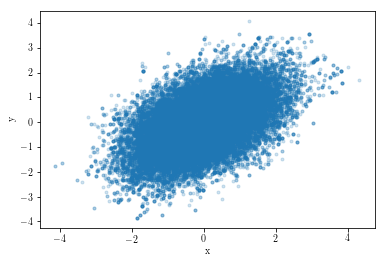

In [0]:

plt.plot(samples[:, 0], samples[:, 1], '.', alpha = 0.2)
plt.xlabel('x') # because the first variable in ln_like is x
plt.ylabel('y') # because the second variable in ln_like is y
plt.show()

It almost looks like a 2D gaussian distribution. There are many ways to make the plots look better, and you can use existing packages to plot these sampled values. Here, we are using the `ChainConsumer` to improve the presentation. 

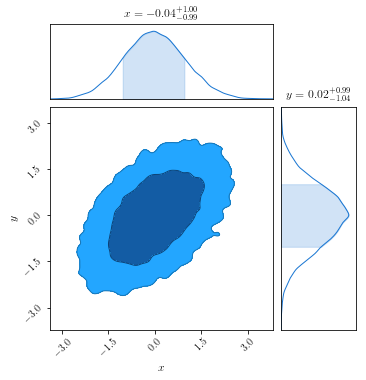

In [0]:
from chainconsumer import ChainConsumer
c = ChainConsumer()
c.add_chain(samples, parameters=[r"$x$", r"$y$"])
c.plotter.plot(figsize="column")
plt.show()

So that worked. In real applications, there are several **important** things to note when using MCMC samplers.

* MCMC algorithms generally require some burn-ins. The first a few values from the output is usually not representative of the PDF specified by the log likelihood. People often throw away the beginning of the samples in further analysis. How much to throw away depend on your inital values and on the complexity of the log-likelihood.
* You'd probably want to sample many more sets of values in real applications. 5000 is generally a very small number to get a set of values representative of the PDF specified by the log likelihood. 
* Please read the manual for how to initiate the emcee sampler, and for specifying the `nwalkers` and for how to perform burn-ins. The specification above works for the 2D Gaussian distribution, but likely will not work for more complicated distributions. 


**Exercises**

*   Try to change the parameters of the Gaussian distributions, and see how the sampling results change.
*   Try to run the sampler for longer times, by using a larger `nstep` value and see if you can get a smoother distribution.



# MCMC and Bayes analysis. 

You may be wondering, why do we bother to use MCMC to sample a known distribution? 

Part of the reason is that MCMC is particularly powerful when combined with Bayes analysis, when we want to know the distribution of some model parameters, given a set of observational data $\{x\}$. 

Let's say that we want to understand the distribution of some parameters $\theta$ given some data $x$. Bayes' theorem states that the following is true:
$$ P(\theta | x) = \frac{P(\theta)\;P(x | \theta)}{P(x)} $$
$P(\theta | x)$, what we're after, is known as the posterior distribution. $P(\theta)$ is known as the prior and represents our prior knowledge (if any) about the parameters in our model. $P(x | \theta)$ is the likelihood of the data given the parameters. Finally, $P(x)$ is known as the evidence. In general, the evidence is difficult to compute. Fortunately, we usually don't need to calculate it, as it serves only as a normalization constant. Therefore, we can refer to the posterior distribution as
$$ P(\theta|x) \propto P(\theta)\;P(x|\theta) $$. 

This posterior distribution can look rather complicated depending on the models we are exploring. 
There's a few things we'll want to do with the posterior distribution. Firstly, we may want to visualize the $\theta$ values. Additionally, we may want to integrate over some parameters. These are easier to do when we can draw a sample of $\theta$ values from the MCMC distribution using MCMC! 

**Example**

As a example, let's imagine that we have a set of data $\{x_i\}$ that has been drawn from a gaussian distribution, with a mean $\mu$, and variance $\sigma^2$ unknown to us, $P(x) = \frac{1}{\sigma \sqrt{2 \pi}} \mathrm{exp} \left[ -\frac{1}{2}\frac{(x-\mu)^2 }{\sigma^2}\right]$. 

We'll assume that the prior distribution of $\mu$ and $\sigma$ is uniformly distributed over a unknown space, then the posterior distribution of $(\mu, \sigma)$ would be 

$$P(\mu, \sigma | \{x_i \}) \propto \prod_{i} \left ( \frac{1}{\sigma \sqrt{2 \pi}} \mathrm{exp} \left[ -\frac{1}{2}\frac{(x_i-\mu)^2 }{\sigma^2}\right] \right)$$

$$\mathrm{Log} P(\mu, \sigma | \{x_i \}) \propto -\frac{1}{2} \sum_{i}\frac{(x_i-\mu)^2 }{\sigma^2} - N\times\mathrm{log}\sigma$$. 

Now let's first generate a set of "data" -- we'll just do so using a Normal distribution with $\mu = 0$, $\sigma = 1.0$.

In [1]:
x_data=np.random.randn(100) # this is generating 100 observational data points.

plt.hist(x_data);plt.show()

NameError: ignored

Next, we'll set up the log likelihood function, and then run the emcee sampler. 

In [0]:
import emcee
import numpy as np
import time


def ln_like(theta):
        mu, sigma =theta
        lp=-np.inf
        if sigma > 0: # sigma needs to be larger than 0 to make the calculation valid.
          lp= np.sum( -0.5*(x_data-mu)**2/sigma**2  - np.log(sigma) )
        return lp

ndim=2 # because we sample a 2-D distribution
nwalkers=10 # Related to the emcee package. 10 is enough here. Consult emcee manual when setting up your own sampling process.

sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_like, args=() )  # setting up the emcee sampler


t0 = time.time() # just for some extra fun, we are recording how much time the sampling takes. 
# emcee sampler needs to be "initiated", e.g., what (x, y) values to start on. 
# Consult the manual when setting up your own initialization values
# here I am trying to give some bad guesses to give the sampler a harder time.
p0=np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim)) * 0.001 

# now let's start sampling
nstep =5000 # this says that we want to sample nstep=10000 sets of (x,y) values
pos, prob, state = sampler.run_mcmc(p0, nstep)
samples = sampler.chain[:, :, :].reshape((-1, ndim)) # here is the sampled sets of (x, y) values. 
t1=time.time()
print( ' Done with sampling -- time (seconds): ',t1-t0)

(' Done with sampling -- time (seconds): ', 3.3728690147399902)


Now we can plot the posterior distribution of $\mu$ and $\sigma$. Note that $\sigma$ isn't a Gaussian distribution!

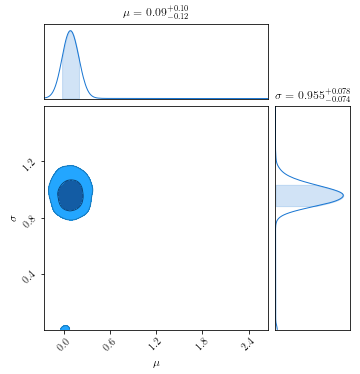

In [0]:
from chainconsumer import ChainConsumer
c = ChainConsumer()
c.add_chain(samples, parameters=[r"$\mu$", r"$\sigma$"])
c.plotter.plot(figsize="column")
plt.show()